# Text Classification with BERT in Pytorch

@description: It is a Python3 file to implement text classification with BERT in Pytorch.

@author: Yantong Lai

@date: 01/14/2020

## 0. Install transformers

In [1]:
! pip3 install transformers

In [1]:
import transformers

transformers.__version__

'4.38.2'

## 1. Data Pre-processing

### 1.1 Configure CPU

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

### 1.2 Read dataset file

We use the Yelp provided polarity dataset for text classification. You could download the Yelp polarity dataset via [link](https://www.kaggle.com/irustandi/yelp-review-polarity/version/1#test.csv) in Kaggle.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

# filename = "/content/drive/MyDrive/Hate Speech_Multilingual /Code/Dataset Statistics/english_curated(multi).csv"
filename = 'G:\My Drive\Hate Speech_Multilingual\Code\Dataset Statistics\english_curated(multi).csv'

df = pd.read_csv(filename)
df = df[['class', 'text']]
df.columns = ['label', 'text']

Take a look at the train data and test data.

In [4]:
df.head()

,label,text
0,1,If America had another 8 years of Obama's ideo...
1,1,@user queue is fucking retarded it makes every...
2,1,@user Que ce ne soit pas des Burundais refugie...
3,0,@user @user Btw. Are we now allowed to say \sh...
4,1,@user Still a bitter cunt. Why so much interes...


In [12]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [13]:
df_train['label'].value_counts(), df_test['label'].value_counts()

(label
 0    64305
 1    41014
 Name: count, dtype: int64,
 label
 0    16076
 1    10254
 Name: count, dtype: int64)

### 1.3 Get the values of DataFrame

In [8]:
train_labels = df_train['label'].tolist()
train_text = df_train['text'].tolist()

test_labels = df_test['label'].tolist()
test_text = df_test['text'].tolist()

assert len(train_labels) == len(train_text)
assert len(test_labels) == len(test_text)

print("len(train_text) = {}, len(test_text) = {}".format(len(train_text), len(test_text)))

len(train_text) = 105319, len(test_text) = 26330


## 2. BERT Tokenization & Input Formatting

### 2.1 BERT Tokenization

In [9]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Let's apply the tokenizer to one sentence just to see the output.**

In [10]:
# Print the original sentence.
print('Original: ', train_text[0])
print("len(Original) = ", len(train_text[0]))
print("\n")

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_text[0]))
print("len(Tokenized) = ", len(tokenizer.tokenize(train_text[0])))
print("\n")

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0])))
print("len(Token IDs) = ", len(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0]))))
print("\n")

Original:  i am thankful for dishwashers. #thankful #positive     
len(Original) =  55


Tokenized:  ['i', 'am', 'thankful', 'for', 'dish', '##wash', '##ers', '.', '#', 'thankful', '#', 'positive']
len(Tokenized) =  12


Token IDs:  [1045, 2572, 18836, 2005, 9841, 28556, 2545, 1012, 1001, 18836, 1001, 3893]
len(Token IDs) =  12




### 2.2 Input Formatting for BERT

**BERT needs adding special tokens --- [cls] and [sep]**

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

Oddly, this function can perform truncating for us, but doesn't handle padding.

**Encoding for text in training dataset**

In [11]:
import logging

# Set logger to avoid warning `token indices sequence length is longer than the specified maximum sequence length for this model (1017 > 512)`
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)


def text_to_id(tokenizer, text_list):
    """
    It is a function to transform text to id.
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    """
    ids_list = []

    for item in text_list:
        # Sentence to id and add [CLS] and [SEP]
        encoded_item = tokenizer.encode(item, add_special_tokens=True)
        ids_list.append(encoded_item)

    return ids_list

In [12]:
train_text_ids = text_to_id(tokenizer, train_text)
test_text_ids = text_to_id(tokenizer, test_text)


# Print sentence 0, now as a list of IDs.
print('Original: {}\n'.format(train_text[0]))
print('Token IDs: {}\n'.format(train_text_ids[0]))
print("len(train_text_ids) = {}\n".format(len(train_text_ids)))
print("len(test_text_ids) = {}".format(len(test_text_ids)))

Original: i am thankful for dishwashers. #thankful #positive     

Token IDs: [101, 1045, 2572, 18836, 2005, 9841, 28556, 2545, 1012, 1001, 18836, 1001, 3893, 102]

len(train_text_ids) = 105319

len(test_text_ids) = 26330


**Calculate the maximum length of train_text_ids**

In [13]:
print('Train: max sentence length: ', max([len(sen) for sen in train_text_ids]))
print('Train: Min sentence length: ', min([len(sen) for sen in train_text_ids]))
print('Test: max sentence length: ', max([len(sen) for sen in test_text_ids]))
print('Test: Min sentence length: ', min([len(sen) for sen in test_text_ids]))

Train: max sentence length:  315
Train: Min sentence length:  4
Test: max sentence length:  349
Test: Min sentence length:  4


From above results, we could find that the length of each sentence in `train_text_ids` is not the same, so we need to pad or truncate the text ids.

### 2.3 Padding & Truncating

In [14]:
def padding_truncating(input_ids_list, max_length):
    """
    It is a function to perform padding and truncating
    @param input_ids_list: <List> text_ids
    @param max_length: <Integer> the number we wanna the sentence to be padding or truncating
    @return: processed input_ids_list
    """
    processed_input_ids_list = []
    for item in input_ids_list:
        seq_list = []

        if len(item) < max_length:
            # Define a seq_list with the length of max_length
            seq_list = [0] * (max_length - len(item))
            item = item + seq_list

        elif len(item) >= max_length:
            item = item[:max_length]

        processed_input_ids_list.append(item)

    return processed_input_ids_list

**Padding or truncating the `train_text_ids` and `test_text_ids`**

In [15]:
train_padding_list = padding_truncating(train_text_ids, max_length=50)
test_padding_list = padding_truncating(test_text_ids, max_length=50)

### 2.4 Attention Masks

The attention mask simply makes it explicit which tokens are actual words versus which are padding. The `BERT` vocabulary does not use the ID 0, so **if a token ID is 0, it's a padded one, and otherwise it's a real token**.

In [16]:
def get_attention_masks(pad_input_ids_list):
    """
    It is a function to get attention masks:

    - If a token ID is 0, then it's padding, set the mask to 0.
    - If a token ID is > 0, then it's a real token, set the mask to 1.
    """
    attention_masks_list = []

    for item in pad_input_ids_list:

        mask_list = []
        for subitem in item:
            if subitem > 0:
                mask_list.append(1)
            else:
                mask_list.append(0)
        attention_masks_list.append(mask_list)

    return attention_masks_list

In [17]:
train_attention_masks = get_attention_masks(train_padding_list)
test_attention_masks = get_attention_masks(test_padding_list)

assert len(train_text) == len(train_labels) == len(train_attention_masks) == len(train_padding_list)
assert len(test_text) == len(test_labels) == len(test_attention_masks) == len(test_padding_list)

### 2.5 Split train dataset into train_dataset and validation_dataset

In [18]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_padding_list, validation_padding_list, train_labels, validation_labels, train_attention_masks, validation_attention_masks = train_test_split(train_padding_list, train_labels, train_attention_masks, random_state=2020, test_size=0.1)

In [19]:
assert len(train_labels) == len(train_attention_masks) == len(train_padding_list)
assert len(validation_labels) == len(validation_attention_masks) == len(validation_padding_list)
assert len(test_labels) == len(test_attention_masks) == len(test_padding_list)

In [20]:
print("len(train_labels) = {}\nlen(validation_labels) = {}\nlen(test_labels) = {}".format(len(train_labels), len(validation_labels), len(test_labels)))

len(train_labels) = 94787
len(validation_labels) = 10532
len(test_labels) = 26330


### 2.6 Convert to Dataset

#### 2.6.1 Convert all the `List` objects to tensor

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Convert all inputs and labels into torch tensors, the required datatype for our model.
train_inputs = torch.tensor(train_padding_list)
validation_inputs = torch.tensor(validation_padding_list)
test_inputs = torch.tensor(test_padding_list)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_attention_masks)
validation_masks = torch.tensor(validation_attention_masks)
test_masks = torch.tensor(test_attention_masks)

#### 2.6.2 Form the Dataset with torch.tensor

In [22]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 256

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## 3. Train BERT Text Classification Model

### 3.1 BertForSequenceClassification

**Load `BertForSequenceClassification` from `transformers`**

In [23]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
import torch

# Load BertForSequenceClassification, the pretrained BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Use the 12-layer BERT model, with an uncased vocab.
     num_labels = 2,      # The number of output labels -- 2 for binary classification.
                    # You can increase this for multi-class tasks.
     output_attentions = False, # Whether the model returns attentions weights.
     output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### 3.2 Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (We chose 32 when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
- Number of epochs: 2, 3, 4  (We'll use 4).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [24]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
print("total_steps = {}".format(total_steps))

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

total_steps = 1855


### 3.3 Train

In [30]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [31]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [32]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 12345

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(epochs):

    ##########################################
    #               Training                 #
    ##########################################

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 10 batches.
        if step % 10 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear the gradients.
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we have provided the `labels`.
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()

        # Perform a `backward` pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))


    ##########################################
    #               Validation               #
    ##########################################
    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to device
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        # flat_accuracy(y_pred, y_true)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    10  of    371.    Elapsed: 0:00:17.
  Batch    20  of    371.    Elapsed: 0:00:34.
  Batch    30  of    371.    Elapsed: 0:00:51.
  Batch    40  of    371.    Elapsed: 0:01:09.
  Batch    50  of    371.    Elapsed: 0:01:27.
  Batch    60  of    371.    Elapsed: 0:01:45.
  Batch    70  of    371.    Elapsed: 0:02:03.
  Batch    80  of    371.    Elapsed: 0:02:20.
  Batch    90  of    371.    Elapsed: 0:02:38.
  Batch   100  of    371.    Elapsed: 0:02:56.
  Batch   110  of    371.    Elapsed: 0:03:14.
  Batch   120  of    371.    Elapsed: 0:03:32.
  Batch   130  of    371.    Elapsed: 0:03:50.
  Batch   140  of    371.    Elapsed: 0:04:07.
  Batch   150  of    371.    Elapsed: 0:04:25.
  Batch   160  of    371.    Elapsed: 0:04:43.
  Batch   170  of    371.    Elapsed: 0:05:01.
  Batch   180  of    371.    Elapsed: 0:05:19.
  Batch   190  of    371.    Elapsed: 0:05:37.
  Batch   200  of    371.    Elapsed: 0:05:54.
  Batch   210  of

### 3.4 Plot

**Plot the average loss in training**

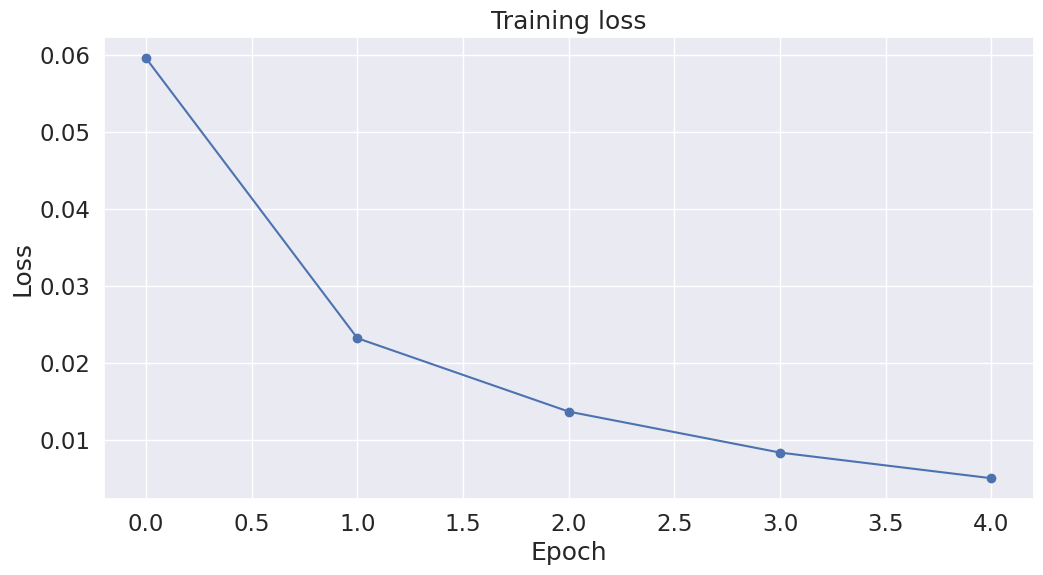

In [33]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### 3.5 Evaluation

In [39]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
idx = 0
correct = 0
for batch in test_dataloader:

    print("Batch {}".format(idx + 1))
    idx += 1

    # Add batch to device
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)

    # Get the prediction probability
    logits = outputs[0]

    logits = logits.cpu()

    # Get the prediction label
    pred = np.argmax(logits, axis=1)
    b_labels = b_labels.cpu()


    # Get the total correct number between pred and true labels in each batch
    correct += (pred == b_labels).sum().item()
    print("correct = {}\n".format(correct))


print('DONE.')
print("Total correct = ", correct)
print("Test accuracy = {0:.2f}".format(correct / len(test_inputs)))

Predicting labels for 26,330 test sentences...
Batch 1
correct = 254

Batch 2
correct = 509

Batch 3
correct = 764

Batch 4
correct = 1012

Batch 5
correct = 1266

Batch 6
correct = 1518

Batch 7
correct = 1774

Batch 8
correct = 2027

Batch 9
correct = 2280

Batch 10
correct = 2535

Batch 11
correct = 2788

Batch 12
correct = 3040

Batch 13
correct = 3292

Batch 14
correct = 3545

Batch 15
correct = 3795

Batch 16
correct = 4046

Batch 17
correct = 4298

Batch 18
correct = 4553

Batch 19
correct = 4806

Batch 20
correct = 5061

Batch 21
correct = 5316

Batch 22
correct = 5571

Batch 23
correct = 5820

Batch 24
correct = 6075

Batch 25
correct = 6328

Batch 26
correct = 6581

Batch 27
correct = 6834

Batch 28
correct = 7087

Batch 29
correct = 7338

Batch 30
correct = 7589

Batch 31
correct = 7844

Batch 32
correct = 8099

Batch 33
correct = 8351

Batch 34
correct = 8606

Batch 35
correct = 8862

Batch 36
correct = 9115

Batch 37
correct = 9368

Batch 38
correct = 9617

Batch 39
correc

In [42]:
len(test_dataloader)

103

In [52]:
# Initialize variables to track total batches and instances
total_batches = len(test_dataloader)
total_instances = 0

# Iterate through the dataloader to count instances
for batch in test_dataloader:
    # Each batch is a tuple (b_input_ids, b_input_mask, b_labels)
    # Increment total_instances by the size of the batch
    total_instances += batch[0].size(0)  # batch[0] is b_input_ids, size(0) gives batch size

# Print or use the total batches and instances
print("Total batches:", total_batches)
print("Total instances:", total_instances)

Total batches: 103
Total instances: 26330


### 3.6 Saving Trained Model

In [53]:
import os

saved_model_dir = "/content/drive/MyDrive/Hate Speech_Multilingual /Code/saved_models/"

if not os.path.exists(saved_model_dir):
    os.makedirs(saved_model_dir)

# Save model to the saved_model_dir
model.save_pretrained(saved_model_dir)
tokenizer.save_pretrained(saved_model_dir)

('/content/drive/MyDrive/Hate Speech_Multilingual /Code/saved_models/tokenizer_config.json',
 '/content/drive/MyDrive/Hate Speech_Multilingual /Code/saved_models/special_tokens_map.json',
 '/content/drive/MyDrive/Hate Speech_Multilingual /Code/saved_models/vocab.txt',
 '/content/drive/MyDrive/Hate Speech_Multilingual /Code/saved_models/added_tokens.json')

### 3.7 Load Trained Model

In [54]:
# Load a trained model and vocabulary that you have fine-tuned

# Model_class: BertForSequenceClassification, XLNetForSequenceClassification, XLMForSequenceClassification, RobertaForSequenceClassification
load_model = BertForSequenceClassification.from_pretrained(saved_model_dir)

# Tokenizer_class: BertTokenizer, XLNetTokenizer, XLMTokenizer, RobertaTokenizer
load_tokenizer = BertTokenizer.from_pretrained(saved_model_dir)